In [45]:
import warnings
warnings.simplefilter("ignore", UserWarning)
import torch
from torch import nn
import pytorch_lightning as pl
from typing import Callable
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import optuna
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
from pytorch_lightning import seed_everything
import logging
from colorama import Fore

In [2]:
seed_everything(42, workers=True)
MAX_EPOCHS = 30
BATCH_SIZE = 1024

Global seed set to 42


In [3]:
def get_data(dataset_getter):
    train_dataset, val_dataset = [
        dataset_getter(
            root="data",
            train=kind == "train",
            download=True,
            transform=transforms.ToTensor(),
        )
        for kind in ["train", "val"]
    ]
    return train_dataset, val_dataset, DataLoader(
        train_dataset,
        pin_memory=True,
        batch_size=BATCH_SIZE,
        shuffle=True
    ), DataLoader(
        val_dataset,
        pin_memory=True,
        batch_size=BATCH_SIZE,
    )

In [4]:
train_dataset_mnist, val_dataset_mnist, train_loader_mnist, val_loader_mnist = get_data(datasets.MNIST)
train_dataset_fashion, val_dataset_fashion, train_loader_fashion, val_loader_fashion = get_data(datasets.FashionMNIST)

In [5]:
def train_loss(y_hat, y):
    return nn.functional.cross_entropy(y_hat, y)


def val_acc(y_hat, y):
    return (y_hat.argmax(1) == y).float().mean()


class MyCNN(pl.LightningModule):
    def __init__(
            self,
            n_classes: int,
            n_blocks: int,
            kernel_size: int,
            channel_multiplier: int,
            activation_function: Callable[[], nn.modules.Module],
            hidden_size: int,
            input_size: tuple[int, int] = (28, 28),
    ):
        super().__init__()
        self.save_hyperparameters()
        blocks = []
        for i in range(n_blocks):
            blocks.append([
                nn.Conv2d(
                    in_channels=channel_multiplier ** i,
                    out_channels=channel_multiplier ** (i + 1),
                    kernel_size=kernel_size,
                    padding=kernel_size // 2,
                ),
                activation_function(),
                nn.MaxPool2d(kernel_size=2)
            ])

        self.feature_extractor = nn.Sequential(
            *[layer for block in blocks for layer in block]
        )

        out_width = input_size[0] // (2 ** n_blocks)
        out_height = input_size[1] // (2 ** n_blocks)
        out_channels = channel_multiplier ** n_blocks
        self.classifier = nn.Sequential(
            nn.Linear(out_width * out_height * out_channels, hidden_size),
            activation_function(),
            nn.Linear(hidden_size, n_classes),
            nn.Softmax(dim=1),
        )

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = train_loss(y_hat, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        acc = val_acc(y_hat, y)
        self.log("val_acc", acc, on_step=True, on_epoch=True)
        return acc

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.flatten(start_dim=1)
        classes = self.classifier(features)
        return classes

In [6]:
def get_trainer(enable_progress_bar=False):
    return pl.Trainer(
        enable_progress_bar=enable_progress_bar,
        enable_checkpointing=False,
        gpus=-1,
        auto_select_gpus=True,
        amp_level='O3',
        amp_backend='apex',
        max_epochs=MAX_EPOCHS,
        callbacks=[
            EarlyStopping(monitor="val_acc", patience=5, min_delta=0.001, mode="max")
        ],
    )

In [7]:
def make_activation_function(name: str) -> Callable[[], nn.Module]:
    return {
        "ReLU": nn.ReLU,
        "Tanh": nn.Tanh,
        "Leaky": nn.LeakyReLU,
    }[name]

In [8]:
def do_train(trial: optuna.trial.Trial):
    activation_function_name = trial.suggest_categorical(
        "activation_function", ["ReLU", "Tanh", "Leaky"]
    )
    activation_function = make_activation_function(activation_function_name)
    model = MyCNN(
        activation_function=activation_function,
        channel_multiplier=trial.suggest_int("channel_multiplier", 2, 10),
        hidden_size=trial.suggest_int("hidden_size", 10, 1000),
        n_blocks=trial.suggest_int("n_blocks", 1, 3),
        kernel_size=trial.suggest_int("kernel_size_div_by_2", 1, 3) * 2 + 1,
        n_classes=10,
        input_size=(28, 28),
    )
    trainer = get_trainer()
    trainer.fit(model, train_dataloaders=train_loader_mnist, val_dataloaders=val_loader_mnist)
    res = trainer.validate(model, dataloaders=val_loader_mnist, verbose=False)
    return res[0]["val_acc"]

In [9]:
# logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
# study = optuna.create_study(direction="maximize")
# study.optimize(do_train, n_trials=50, show_progress_bar=True)
# logging.getLogger("pytorch_lightning").setLevel(logging.INFO)

In [10]:
# study.best_params

In [11]:
# study.best_value

In [12]:
# best_params = study.best_params

In [13]:
# print(best_params)

In [14]:
best_params = {'activation_function': 'Leaky',
               'channel_multiplier': 10,
               'hidden_size': 613,
               'n_blocks': 3,
               'kernel_size_div_by_2': 2
               }

In [15]:
model_mnist = MyCNN(
    activation_function=make_activation_function(best_params["activation_function"]),
    channel_multiplier=best_params["channel_multiplier"],
    hidden_size=best_params["hidden_size"],
    n_blocks=best_params["n_blocks"],
    kernel_size=best_params["kernel_size_div_by_2"] * 2 + 1,
    n_classes=10,
    input_size=(28, 28),
)
pl.utilities.model_summary.ModelSummary(model_mnist, max_depth=-1)

   | Name                | Type       | Params
----------------------------------------------------
0  | feature_extractor   | Sequential | 2.5 M 
1  | feature_extractor.0 | Conv2d     | 260   
2  | feature_extractor.1 | LeakyReLU  | 0     
3  | feature_extractor.2 | MaxPool2d  | 0     
4  | feature_extractor.3 | Conv2d     | 25.1 K
5  | feature_extractor.4 | LeakyReLU  | 0     
6  | feature_extractor.5 | MaxPool2d  | 0     
7  | feature_extractor.6 | Conv2d     | 2.5 M 
8  | feature_extractor.7 | LeakyReLU  | 0     
9  | feature_extractor.8 | MaxPool2d  | 0     
10 | classifier          | Sequential | 5.5 M 
11 | classifier.0        | Linear     | 5.5 M 
12 | classifier.1        | LeakyReLU  | 0     
13 | classifier.2        | Linear     | 6.1 K 
14 | classifier.3        | Softmax    | 0     
----------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.200    Total estimated model params size (MB)

In [16]:
trainer = get_trainer()
trainer.fit(model_mnist, train_dataloaders=train_loader_mnist, val_dataloaders=val_loader_mnist)
res = trainer.validate(model_mnist, dataloaders=val_loader_mnist)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 2.5 M 
1 | classifier        | Sequential | 5.5 M 
-------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.200    Total estimated model params size (MB)
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9926999807357788, 'val_acc_epoch': 0.9926999807357788}
--------------------------------------------------------------------------------


In [17]:
model_fashion = MyCNN(
    activation_function=make_activation_function(best_params["activation_function"]),
    channel_multiplier=best_params["channel_multiplier"],
    hidden_size=best_params["hidden_size"],
    n_blocks=best_params["n_blocks"],
    kernel_size=best_params["kernel_size_div_by_2"] * 2 + 1,
    n_classes=10,
    input_size=(28, 28),
)
pl.utilities.model_summary.ModelSummary(model_fashion, max_depth=-1)

   | Name                | Type       | Params
----------------------------------------------------
0  | feature_extractor   | Sequential | 2.5 M 
1  | feature_extractor.0 | Conv2d     | 260   
2  | feature_extractor.1 | LeakyReLU  | 0     
3  | feature_extractor.2 | MaxPool2d  | 0     
4  | feature_extractor.3 | Conv2d     | 25.1 K
5  | feature_extractor.4 | LeakyReLU  | 0     
6  | feature_extractor.5 | MaxPool2d  | 0     
7  | feature_extractor.6 | Conv2d     | 2.5 M 
8  | feature_extractor.7 | LeakyReLU  | 0     
9  | feature_extractor.8 | MaxPool2d  | 0     
10 | classifier          | Sequential | 5.5 M 
11 | classifier.0        | Linear     | 5.5 M 
12 | classifier.1        | LeakyReLU  | 0     
13 | classifier.2        | Linear     | 6.1 K 
14 | classifier.3        | Softmax    | 0     
----------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.200    Total estimated model params size (MB)

In [18]:
trainer = get_trainer()
trainer.fit(model_fashion, train_dataloaders=train_loader_fashion, val_dataloaders=val_loader_fashion)
res = trainer.validate(model_fashion, dataloaders=val_loader_fashion)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 2.5 M 
1 | classifier        | Sequential | 5.5 M 
-------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.200    Total estimated model params size (MB)
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9157000184059143, 'val_acc_epoch': 0.9157000184059143}
--------------------------------------------------------------------------------


In [19]:
n_classes = 10


def draw(model, val_loader):
    cm = torch.zeros(n_classes, n_classes, dtype=torch.int32)
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch
            y_hat = model(x)
            for row, target in zip(y_hat, y):
                pred = row.argmax(dim=0)
                cm[pred, target] += 1
    cm = cm.numpy()
    plt.figure(figsize=(12, 12))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    plt.show()

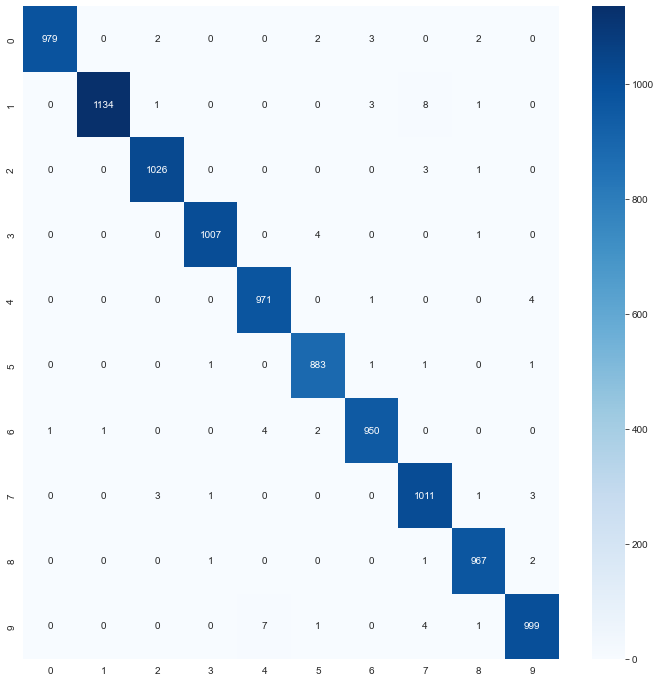

In [20]:
draw(model_mnist, val_loader_mnist)

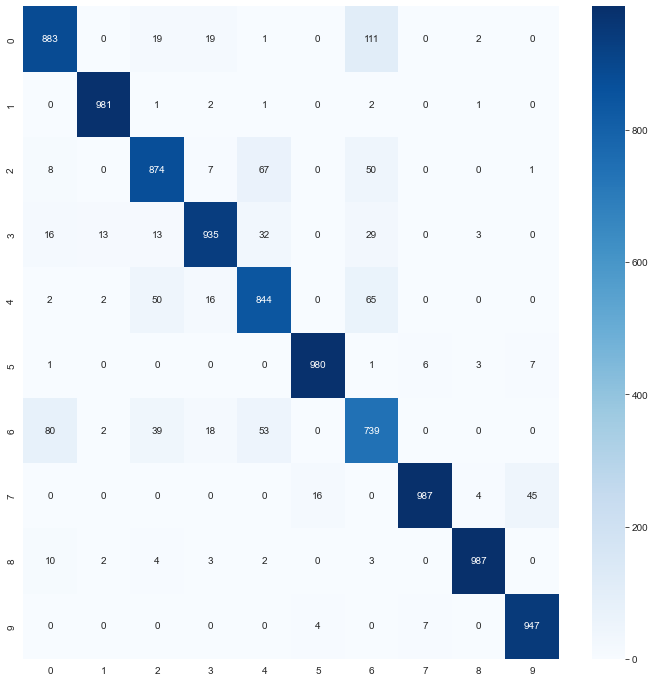

In [21]:
draw(model_fashion, val_loader_fashion)

In [22]:
def draw_err(model, val_dataset):
    _, axs = plt.subplots(n_classes, n_classes, figsize=(12, 12))
    imgs_by_class = [[] for _ in range(n_classes)]
    for (x, y) in val_dataset:
        imgs_by_class[y].append(x)
    for i in range(n_classes):
        imgs = torch.stack(imgs_by_class[i])
        preds = model(imgs)
        for j in range(n_classes):
            most_similar = preds[:, j].argmax(dim=0)
            axs[i, j].imshow(imgs[most_similar].numpy().squeeze(), cmap="gray")
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            axs[0, j].set_title(val_dataset.classes[j])

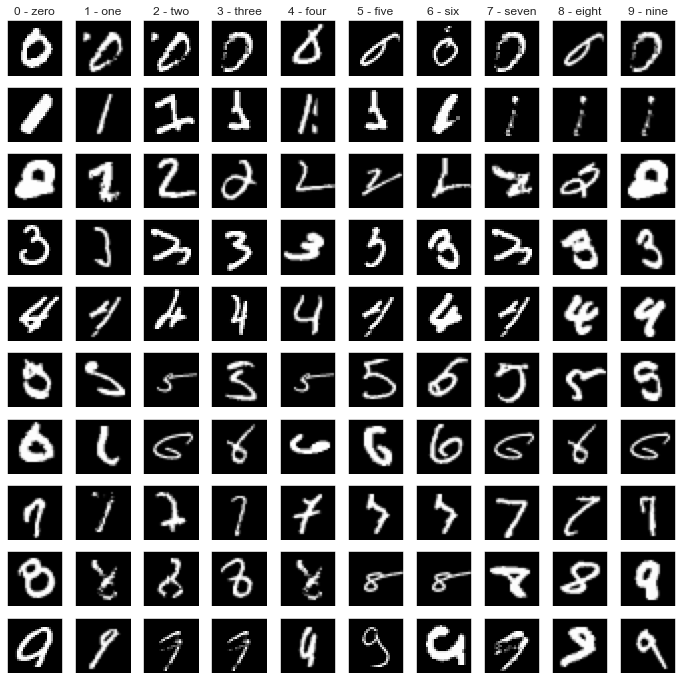

In [23]:
draw_err(model_mnist, val_dataset_mnist)

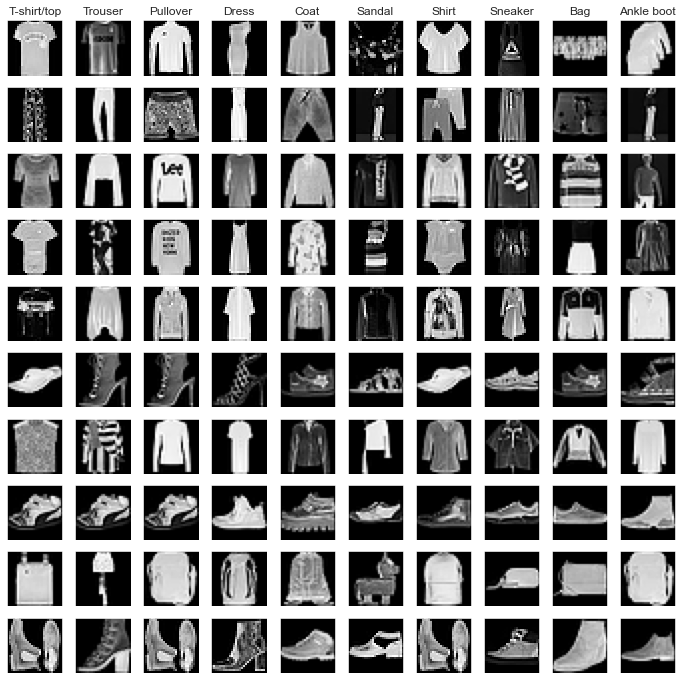

In [24]:
draw_err(model_fashion, val_dataset_fashion)

In [46]:
def print_err(model, val_dataset):
    imgs_by_class = [[] for _ in range(n_classes)]
    for (x, y) in val_dataset:
        imgs_by_class[y].append(x)
    for i in range(n_classes):
        imgs = torch.stack(imgs_by_class[i])
        preds = model(imgs)
        for j in range(n_classes):
            most_similar = preds[:, j].argmax(dim=0)
            probability = preds[:, j][most_similar].item()
            if probability >= 0.1 and i != j:
                color = Fore.RED
            else:
                color = Fore.GREEN
            print(color + "{:.3f}".format(probability), end = '  ')
        print("")

In [47]:
print_err(model_mnist, val_dataset_mnist)

1.000  0.437  0.000  0.001  0.000  0.000  0.767  0.010  0.401  0.004  
0.322  1.000  0.000  0.011  0.000  0.047  0.558  0.000  0.013  0.000  
0.566  0.995  1.000  0.016  0.137  0.000  0.073  1.000  0.326  0.000  
0.195  0.001  0.304  1.000  0.000  0.919  0.000  0.627  0.981  0.182  
0.001  0.341  0.292  0.000  1.000  0.000  0.854  0.004  0.440  1.000  
1.000  0.242  0.000  1.000  0.000  1.000  1.000  0.000  0.087  1.000  
1.000  1.000  0.000  0.000  1.000  0.876  1.000  0.000  0.458  0.012  
0.020  1.000  1.000  0.022  0.182  0.926  0.000  1.000  0.999  1.000  
0.999  0.670  0.668  0.995  0.000  0.049  0.377  1.000  1.000  0.961  
0.083  0.166  0.000  0.030  1.000  0.927  0.020  0.995  0.965  1.000  


In [48]:
print_err(model_fashion, val_dataset_fashion)

1.000  0.006  1.000  1.000  0.996  0.999  1.000  0.002  1.000  0.014  
0.298  1.000  0.057  1.000  0.992  0.004  0.998  0.000  0.999  0.000  
1.000  0.989  1.000  1.000  1.000  0.067  1.000  0.001  0.990  0.001  
1.000  0.990  1.000  1.000  1.000  0.197  1.000  0.296  0.973  0.074  
0.987  1.000  1.000  1.000  1.000  0.006  1.000  0.000  0.771  0.002  
0.056  0.000  0.000  0.005  0.000  1.000  0.000  1.000  0.014  0.975  
1.000  0.959  1.000  1.000  1.000  0.704  1.000  0.104  0.980  0.003  
0.105  0.000  0.000  0.000  0.000  1.000  0.000  1.000  0.052  1.000  
1.000  1.000  0.294  1.000  0.031  0.999  0.096  1.000  1.000  0.002  
0.009  0.000  0.927  0.000  0.000  1.000  0.065  1.000  0.002  1.000  
